# Predikcija i rekonstrukcija nedostajućih tačaka

Ova sveska koristi ALNP model obučen u prethodnom notebooku za generisanje predikcija (rekonstrukcija) svetlosnih kriva i ekstrakciju naučenih latentnih reprezentacija.

In [1]:
import QNPy_Latte.PREDICTION as por 
from QNPy_Latte.PREDICTION import * 
from QNPy_Latte.PREDICTION import plot_function2, back_x, back_y, find_LC_transform

import os
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prikazivanje plotova inline
%matplotlib inline

## 1. Priprema putanja i učitavanje modela

Ovde definišemo sve parametre i putanje potrebne za učitavanje modela, podataka i koeficijenata, kao i za čuvanje rezultata.

In [2]:
full_folder = "output"

# Putanje do podataka
DATA_PATH_TRAIN = os.path.join(full_folder, f"dataset_LCs", "train")
DATA_PATH_VAL = os.path.join(full_folder, f"dataset_LCs", "val")
DATA_PATH_TEST = os.path.join(full_folder, f"dataset_LCs", "test")

# Putanja do modela
MODEL_PATH = os.path.join(full_folder, f"output_LCs", f"model_LCs.pth") 

# Putanja do koeficijenata
TR_COEFF_PATH = os.path.join(full_folder, 'TR_Coeffs', f'trcoeff_LCs.pickle')

# Izlazni direktorijum
OUTPUT_PATH = os.path.join(full_folder, f'output_LCs', 'predictions/')

os.makedirs(OUTPUT_PATH, exist_ok=True)

Neophodno je ponovo definisati hiperparametre koji definišu arhitekturu modela, identično kao u training notebooku, da bi se model mogao pravilno učitati

In [3]:
# Hiperparametri arhitekture
encoding_size = 128
latent_size = 128
no_latent_samples = 10 
attention_type = 'scaledot'
cross_attention = True
self_attention = True
lstm_layers = 0
lstm_size = 32
replace_lstm_with_gru = False
bidirectional = False
lstm_agg = False 
activation = 'relu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_function_length = 0
param_length = 0 

tf_and_param = False
TF_PATH = None
param_df = None
param_columns = []
beta_param = 0
beta_tf = 0

print(f"Hiperparametri za učitavanje modela definisani.")

Hiperparametri za učitavanje modela definisani.


Učitavamo učitamo model.pth fajl u odgovarajuću arhitekturu definisanu hiperparametrima.

In [4]:
# Učitavanje modela
model = por.load_trained_model(
    MODEL_PATH, 
    device, 
    encoding_size,
    latent_size, 
    latent_mlp_size=encoding_size, 
    attention=cross_attention, 
    self_attention=self_attention, 
    no_latent_space_sample=no_latent_samples, 
    lstm_layers=lstm_layers, 
    lstm_agg=lstm_agg, 
    lstm_size=lstm_size, 
    transfer_function_length=transfer_function_length, 
    parameters_length=param_length, 
    classes=0, 
    replace_lstm_with_gru=replace_lstm_with_gru,
    activation=activation, 
    bidirectional=bidirectional,
    attention_type=attention_type
)

# Postavljanje modela u evaluacioni mod
model.eval()

# Učitavanje kriterijuma/metrika
criterion, mseMetric = por.get_criteria()

# Učitavanje koeficijenata
tr_coeffs = por.load_trcoeff(TR_COEFF_PATH)

Kreiramo DataLoadere za `train`, `val` i `test` skupove.

In [5]:
# Broj tačaka za glatku predikciju na plotu
num_target_smooth = 1000 
# Batch size za evaluaciju (obično 1)
eval_batch_size = 1 

# Kreiranje DataLoadera
trainLoader = por.load_train_data(DATA_PATH_TRAIN, num_target_smooth=num_target_smooth, tf_dir=TF_PATH, param_df=param_df, param_columns=param_columns, class_labels_df=None)
valLoader = por.load_val_data(DATA_PATH_VAL, num_target_smooth=num_target_smooth, tf_dir=TF_PATH, param_df=param_df, param_columns=param_columns, class_labels_df=None)
testLoader = por.load_test_data(DATA_PATH_TEST, num_target_smooth=num_target_smooth, tf_dir=TF_PATH, param_df=param_df, param_columns=param_columns, class_labels_df=None)

## 2. Generisanje predikcija i ekstrakcija reprezentacija

Pokrećemo model na svakom skupu podataka. Funkcije plot_... će generisati plotove, izračunati metrike i vratiti latentne reprezentacije.

Inicijalizujemo liste za rezultate

In [6]:
all_names_nested = [] 
all_z_nested = []     
all_R_nested = []     
all_full_rep_nested = [] 

all_predicted_tfs = [] 
all_predicted_params = []

Prvo obrađujemo test skup:

In [7]:
current_names_test = []
for i, batch in enumerate(testLoader):
    lcName = batch.get('lcName', [f'unknown_test_{i}'])[0]
    current_names_test.append(lcName.split('_')[0])

testMetrics, z_test, R_test, agg_R_z_test, predicted_params_test, predicted_tf_test, predicted_classes = \
    por.plot_test_data(
        model, 
        testLoader, 
        criterion, 
        mseMetric, 
        plot_function2, 
        device=device, 
        tr=tr_coeffs, 
        OUTPUT_PATH=OUTPUT_PATH, 
        beta_param=beta_param, 
        beta_classifier=0, 
        beta_tf=beta_tf
    )

all_z_nested.append(z_test)
all_R_nested.append(R_test)
all_full_rep_nested.append(agg_R_z_test)
all_names_nested.append(current_names_test)
all_predicted_tfs.append(predicted_tf_test)
all_predicted_params.append(predicted_params_test)

# Čuvanje metrika za Test skup
savetest_status = por.save_test_metrics(OUTPUT_PATH, testMetrics)

c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


<Figure size 640x480 with 0 Axes>

Zatim i za train skup:

In [8]:
current_names_train = []
for i, batch in enumerate(trainLoader):
    lcName = batch.get('lcName', [f'unknown_train_{i}'])[0]
    current_names_train.append(lcName.split('_')[0])

trainMetrics, z_train, R_train, agg_R_z_train, predicted_params_train, predicted_tf_train, predicted_classes = \
    por.plot_train_light_curves(
        model, 
        trainLoader, 
        criterion, 
        mseMetric, 
        plot_function2, 
        device, 
        tr_coeffs, 
        OUTPUT_PATH, 
        beta_param=beta_param, 
        beta_classifier=0, 
        beta_tf=beta_tf
    )

all_z_nested.append(z_train)
all_R_nested.append(R_train)
all_full_rep_nested.append(agg_R_z_train)
all_names_nested.append(current_names_train)
all_predicted_tfs.append(predicted_tf_train)
all_predicted_params.append(predicted_params_train)

# Čuvanje metrika za Train skup
savetrain_status = por.save_train_metrics(OUTPUT_PATH, trainMetrics)

c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/74 [00:00<?, ?it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 74/74 [00:56<00:00,  1.32it/s]


<Figure size 640x480 with 0 Axes>

Na kraju, identičan proces i za validacioni skup:

In [10]:
current_names_val = []
for i, batch in enumerate(valLoader):
    lcName = batch.get('lcName', [f'unknown_val_{i}'])[0]
    current_names_val.append(lcName.split('_')[0])

valMetrics, z_val, R_val, agg_R_z_val, predicted_params_val, predicted_tf_val, predicted_classes = \
    por.plot_val_curves(
        model, 
        valLoader, 
        criterion, 
        mseMetric, 
        plot_function2, 
        device, 
        tr_coeffs, 
        OUTPUT_PATH, 
        beta_param=beta_param, 
        beta_classifier=0, 
        beta_tf=beta_tf
    )

all_z_nested.append(z_val)
all_R_nested.append(R_val)
all_full_rep_nested.append(agg_R_z_val)
all_names_nested.append(current_names_val)
all_predicted_tfs.append(predicted_tf_val)
all_predicted_params.append(predicted_params_val)

# Nema posebne funkcije za čuvanje val metrika, preskačemo

c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/14 [00:00<?, ?it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


<Figure size 640x480 with 0 Axes>

Čuvamo prikupljene reprezentacije (`R`, `Z`, kombinovane) i imena u `.pickle` fajlove za kasniju analizu.

In [11]:
# Čuvanje reprezentacija i imena
with open(f'output/LCs_Rs.pickle', 'wb') as handle:
    pickle.dump(all_R_nested, handle)
    
with open(f'output/LCs_zs.pickle', 'wb') as handle:
    pickle.dump(all_z_nested, handle)
    
with open(f'output/LCs_full_reps.pickle', 'wb') as handle:
    pickle.dump(all_full_rep_nested, handle)
    
with open(f'output/LCs_names.pickle', 'wb') as handle:
    pickle.dump(all_names_nested, handle)

print(f"Reprezentacije R, Z, Full i imena sačuvane u .pickle fajlove sa prefiksom: LCs")

Reprezentacije R, Z, Full i imena sačuvane u .pickle fajlove sa prefiksom: LCs


## 3. Vizuelizacija i analiza uspešnosti rekonstrukcije

Prikazujemo jedan od sačuvanih plotova (npr. iz test skupa) da vizuelno proverimo rekonstrukciju i intervale poverenja.

Prikazujem plot: output\output_LCs\predictions/test\plots\15_split3.png


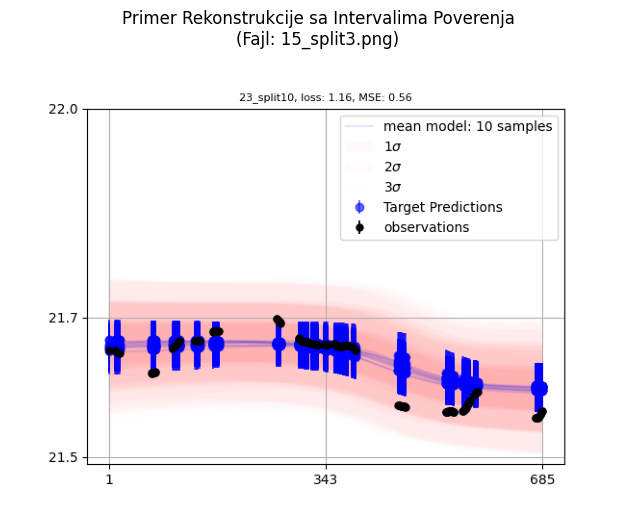

In [ ]:
plot_directory = os.path.join(OUTPUT_PATH, 'test', 'plots') 
plot_files = glob.glob(os.path.join(plot_directory, '*.png'))

# uzimamo neki od plotova
print(f"Prikazujem plot: {plot_files[2]}")
img = mpimg.imread(plot_files[2])
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off') 
plt.title(f"Primer Rekonstrukcije sa Intervalima Poverenja\n(Fajl: {os.path.basename( plot_files[2])})")
plt.show()

Rekonstrukcija ove krive daje solidne rezultate! Iako plave tačke našeg modela ne pogađaju dobro stvarne podatke (crne tačke), one su često na istom mestu i najtamniji roze confidence interval (1 std) hvata dobar deo podataka, a skoro svi su uhvaćeni u (2 std) intervalu. Ipak, ovo je možda lucky hit. Ako pogledamo neki drugi plot:

Prikazujem plot: output\output_LCs\predictions/test\plots\29_split26.png


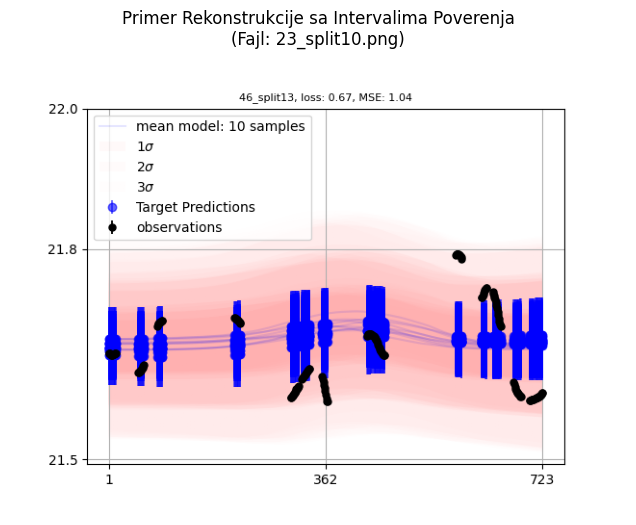

In [ ]:
plot_directory = os.path.join(OUTPUT_PATH, 'test', 'plots') 
plot_files = glob.glob(os.path.join(plot_directory, '*.png'))

# uzimamo neki od plotova
print(f"Prikazujem plot: {plot_files[4]}")
img = mpimg.imread(plot_files[4])
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off') 
plt.title(f"Primer Rekonstrukcije sa Intervalima Poverenja\n(Fajl: {os.path.basename( plot_files[4])})")
plt.show()

Na ovom plotu očigledno vidimo da se naša kriva nije dobro uklopila u realne podatke. Previše je mirna i nedovoljno fleksibilna. Izvor ovog problema je verovatno "KL vanishing" koji smo videli na trećem plotu na kraju prethodnog notebooka. Potencijalno rešenje je množenje KL lossa težinama koje će naterati model da prestane da ga ignoriše.